# Structure From Motion

In this week assignment we are not going to train neural networks for a depth estimation because it requires a lot of GPU resourses.

Instead we are going to solve Structure From Motion using tools that we have. The setting is the following:

We have some 3D points and we have a camera that is moving in 3D. Camera takes shots in different positions. We don't know anything about camera positions and 3D points. Our goal is to estimate both.



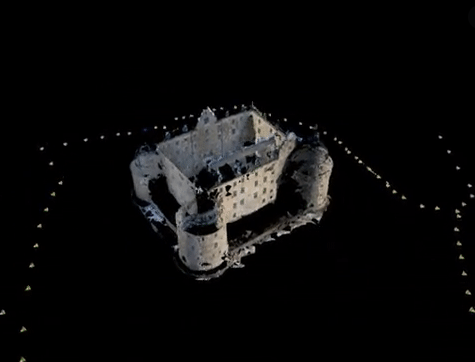

In practice to solve the problem at first we need to construct point correspondencies. In this assignment we provide the correspondencies between points.

We also have the affine projection to simplify our calculations. This setting can occur when we know camera intrinsic (which is a reasonable assumption) and only position of the camera is unknown.

For each camera we have a corresponding projection matrix $P_i$.

$$
P_i = 
\begin{pmatrix}
a_{11} & a_{12} & a_{13} & t_1 \\
a_{21} & a_{22} & a_{23} & t_2 \\
0 & 0 & 0 & 1
\end{pmatrix} =
\begin{bmatrix}
A_i & t_i \\
0 & 1
\end{bmatrix}
$$

Then if we have some 3D point $\mathbf{X}_i$, then projection to the j-th camera is equal to

$$
\mathbf{x}_{ij} = A_j \mathbf{X}_i + t_j 
$$

In our setting we should estimate $A_i$ for each camera and positions of all the points $\mathbf{X}_i$.

If we center (subtract the mean value) all the points inside each camera (let denote this points $\hat{\mathbf{x}}$), than we will be able to estimate centered $\hat{\mathbf{X}}_i$ and $A_j$. In this case:

$$
\hat{\mathbf{x}}_{ij} = A_j\hat{\mathbf{X}}_i
$$

Now let's construct matrix $M$ such that:
$$
M = 
\begin{pmatrix}
\hat{x}_{11} & \hat{x}_{21} & \hat{x}_{31} & ... \\
\hat{y}_{11} & \hat{y}_{21} & \hat{y}_{31} & ... \\
\hat{x}_{12} & \hat{x}_{22} & \hat{x}_{32} & ... \\
\hat{y}_{12} & \hat{y}_{22} & \hat{y}_{32} & ... \\
\end{pmatrix} = 
\begin{bmatrix}
A_1 \\
A_2 \\
A_3 \\
\vdots
\end{bmatrix}
\begin{bmatrix}
\hat{\mathbf{X}}_1 &  \hat{\mathbf{X}}_2 & \hat{\mathbf{X}}_3 & ...
\end{bmatrix}
$$

You can see that first 2 rows is the result of application of matrix $A_1$ to every 3D point.
Our goal is to find this decomposition that minimizes the error between left and right part.
Luckily this decomposition is equivalent to Singular Value Decomposition.
$$
M = UDV^T
$$
So, we just need to perform SVD: first 3 columns of matrix V are the positions of the 3D points. Camera matrices can be obtained by multiplication of the first 3 columns of U by corresponding singular values.

Download the [points](https://www.icloud.com/iclouddrive/00IsoYqEEbFGo0LEQw1_dFpQg#points)

The file contains a numpy array. You can load it by function `np.load()`. 
It contains array of size 10x600x2. For each camera (we have 10 cameras) we have an array of 600 points. Points at the same position are corresponding to each other. It means that `array[:, 0]` is the position of the same point at different cameras. 

1. For each camera substract the mean point of each camera from points of this camera.
2. Construct matrix $M$
3. Find SVD decomposition
4. Extract 3D point positions
5. Visualize 3D points

You can visualize 3D points with the following code.

In [ ]:
'''
import plotly.express as px
fig = px.scatter_3d(x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2])
fig.show()
'''

## Depth Estimation

In this section we are going to work with the trained depth estimation network. This network is a monocular depth method which means that it is capable of working by a single image. Of course, the quality that we can obtain with a single image is lower.

The folowing code downloads the trained network and applies it to the sample image.

In [ ]:
# !pip install timm

In [ ]:
import torch
import cv2
import urllib.request
import matplotlib.pyplot as plt

midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")
midas.eval();

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


Loading weights:  None


In [ ]:
# this part runs preprocessing tools over the image

transform = midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").default_transform
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
prediction = midas(input_batch)

# upscale prediction to the initial resolution
prediction = torch.nn.functional.interpolate(
    prediction.unsqueeze(1),
    size=img.shape[:2],
    mode="bicubic",
    align_corners=False,
).squeeze()

output = prediction.detach().cpu().numpy()

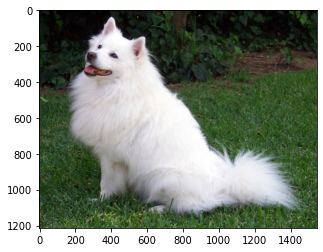

In [ ]:
plt.imshow(img)

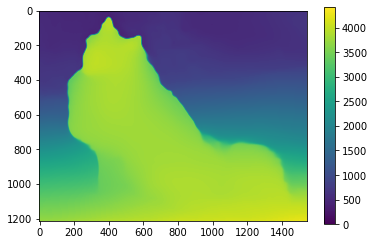

In [ ]:
plt.imshow(output)
plt.colorbar()

Depth estimation allows us to do fasinating things with the images. For example render novel views, apply augmentation reality effects and so on.

Let's add bluring to the background of the image to highlight the dog.

1. Choose depth threshold (network returns inversed depth: higher -> closer) that distinguish dog from the background

2. Apply Gaussian blur with the large kernel size and sigma to obtain a massive blur.

3. Merge two images according to mask: if pixel is closer then threshold than take pixel from the original image, it pixel is far away - take blurred version.

You should obtain something like following.

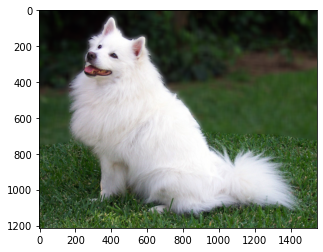

As you can see, there exist border between blurred background and foreground. Do you remember how we can merge two images according to the mask? Laplacian pyramid!

Apply laplacian pyramid image blending to obtain a more smoother border between dog and background.

In [ ]:
# implement laplacian pyramid over the original image, blurred image and distance mask